# Plots to describe the features of the package
---


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#from codegreen_core.tools.carbon_intensity import calculate_for_country
from codegreen_core.tools.carbon_emission import calculate_carbon_footprint_job,calculate_energy_consumption
from codegreen_core.data import energy
from codegreen_core.tools.loadshift_time import predict_optimal_time
import matplotlib.dates as mdates

from datetime import datetime , timedelta
import plot as p
import importlib as il

# from codegreen_core.tools.carbon_emission import calculate_savings_using_ci_data 


In [9]:
Color = {
    "red":"#D6A99A",
    "green":"#99D19C",
    "blue":"#3DA5D9",
    "yellow":"#E2C044",
    "black":"#0F1A20"
}

In [73]:
il.reload(p)
il.reload()

<module 'plot' from '/Users/svj/projects/codegreen/core/docs/plot.py'>

## Hourly renewable percentage 

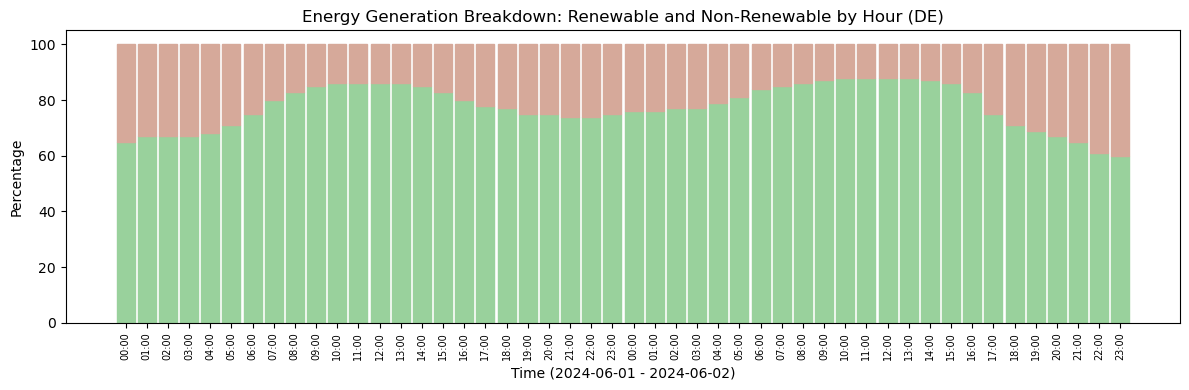

In [70]:
p.show_clean_energy("DE",datetime(2024,6,1),datetime(2024,6,3),"_static/DE_1.png")

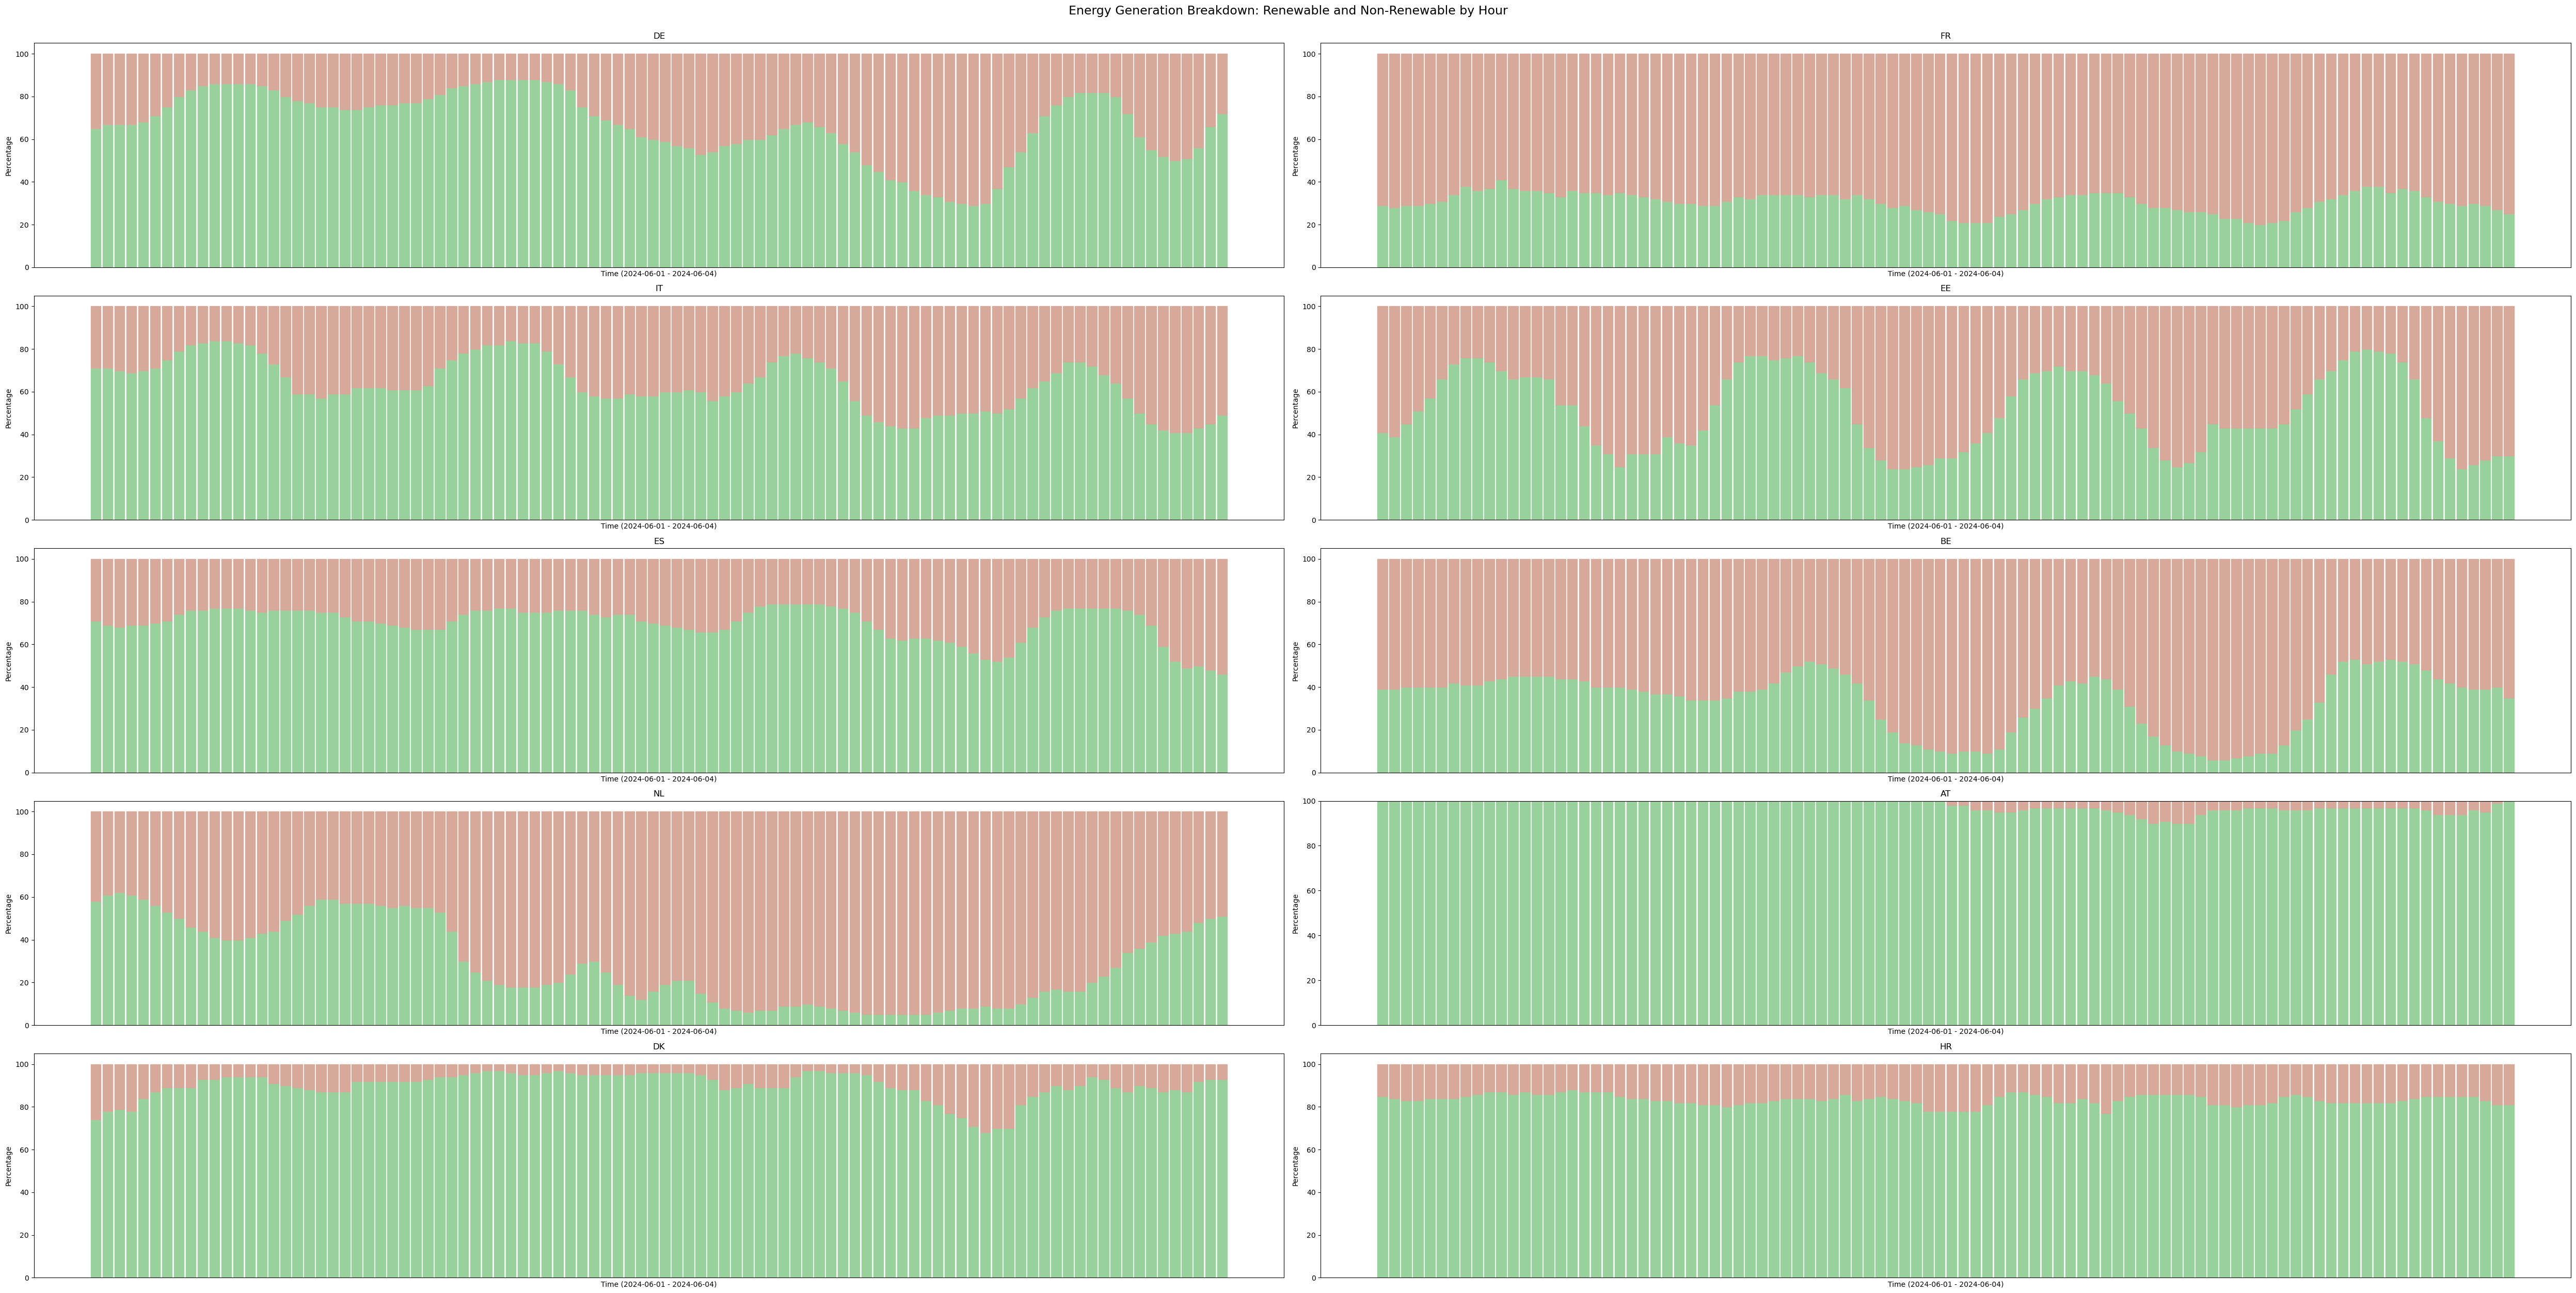

In [75]:
p.show_clean_energy_multiple(["DE","FR","IT","EE","ES","BE","NL","AT","DK","HR"],datetime(2024,6,1),datetime(2024,6,5),"_static/multiple_1.png")



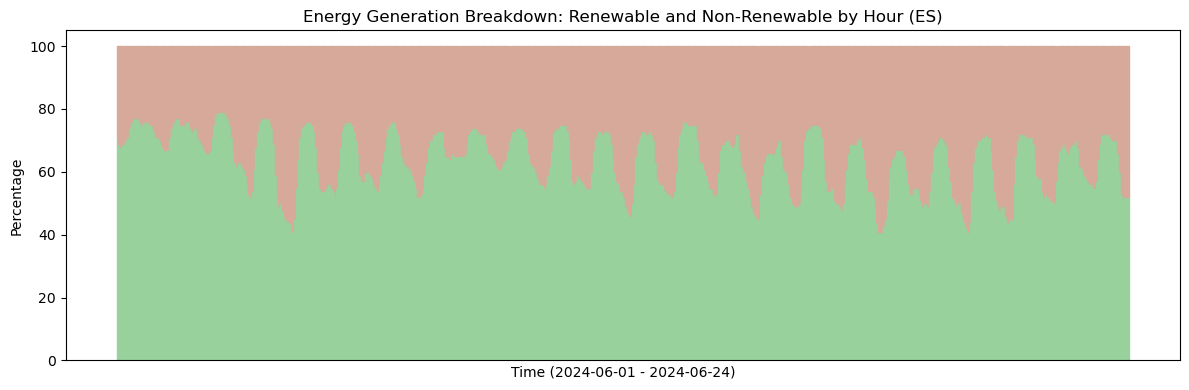

In [77]:
p.show_clean_energy("ES",datetime(2024,6,1),datetime(2024,6,25),"_static/ES_1.png")

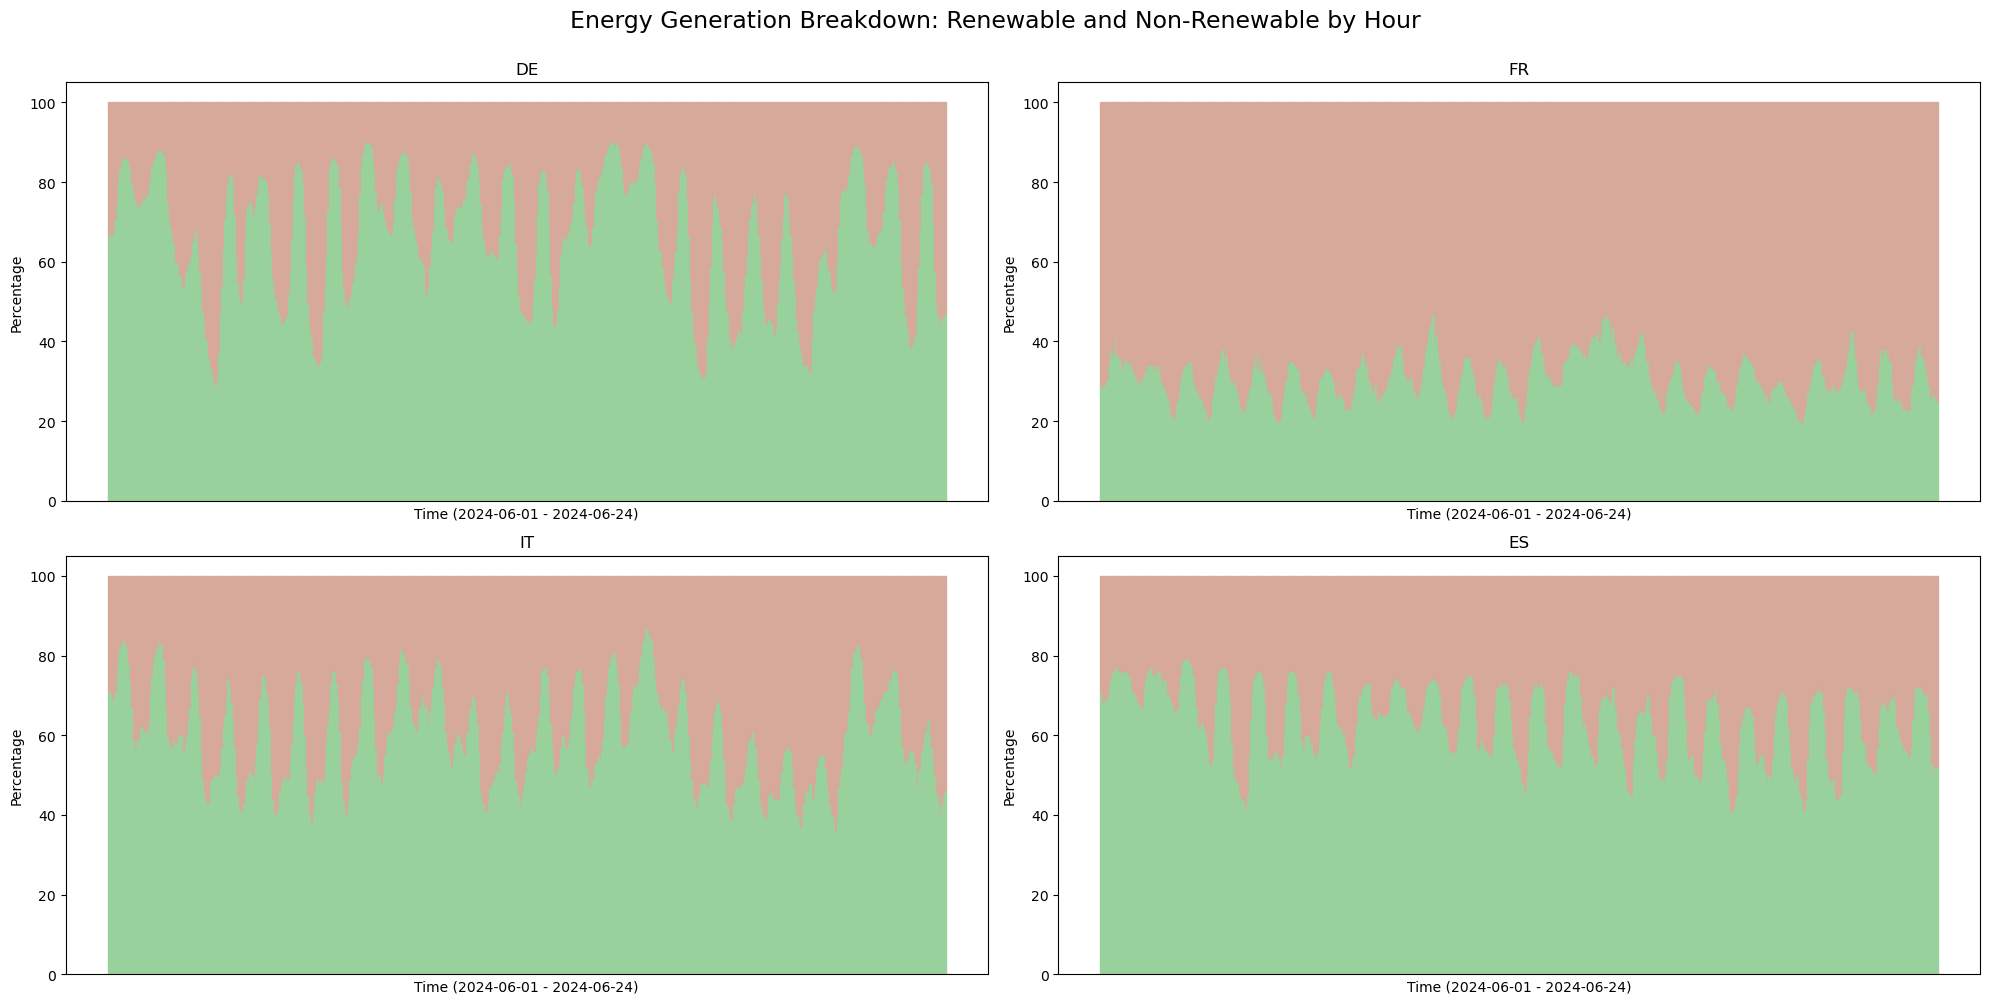

In [79]:
p.show_clean_energy_multiple(["DE","FR","IT","ES"],datetime(2024,6,1),datetime(2024,6,25),"_static/multiple_2.png")


# Country wise comparision 


In [ ]:
def plot_renewables(array_of_dfs, labels=None):
    plt.figure(figsize=(10, 6))  # Create the figure with a custom size

    for i, df in enumerate(array_of_dfs):
        # Plot each dataframe
        label = labels[i] if labels else f"DataFrame {i+1}"
        plt.plot(df['start_time'], df['percentRenewable'], label=label)

    plt.xlabel('Start Time')
    plt.ylabel('Percent Renewable')
    plt.title('Percent Renewable from Different DataFrames')
    plt.legend(loc='best')  # Add legend
    plt.grid(True)  # Add grid for better readability
    plt.xticks(rotation=45)  # Rotate x-ticks for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()


## Optimal Job time

In [25]:
def optimal_job_times(country,start,end,hour,renewPer,n_cores,n_mem_gb):
    energy_data = calculate_for_country(country,start,end) # carbon intensity
    energy_data['startTimeUTC'] = pd.to_datetime(energy_data['startTimeUTC'], utc=True)
    energy_data['posix_timestamp'] = energy_data['startTimeUTC'].astype(int) // 10**9  # Convert to POSIX timestamp (seconds)
    energy_data['percent_renewable'] = energy_data["percentRenewable"]
    
    
def calculate_savings_using_ci_data(ci_ts_input:pd.DataFrame,
                                    start_time: int,
    runtime_minutes: int,
    number_core: int,
    memory_gb: int):
    # runtime_minutes, number_core, power_draw_core, usage_factor_core, mem_size_gb, power_draw_mem, PUE
    e = calculate_energy_consumption(runtime_minutes= runtime_minutes,number_core= number_core, power_draw_core =  15.8,
                                     usage_factor_core=1, mem_size_gb = memory_gb, power_draw_mem = 0.3725 , power_usage_efficiency=1.6)
    e_hour = e/(runtime_minutes*60)
    end_time = datetime.fromtimestamp(start_time)+ timedelta(minutes=runtime_minutes)

    ci_ts = ci_ts_input[(ci_ts_input['startTimeUTC'] >= start_time) & (ci_ts_input['startTimeUTC'] <= end_time)].copy()
    
    ci_ts["carbon_emission"] = ci_ts["ci_default"] * e_hour
    ce = round(sum(ci_ts["carbon_emission"]),4) # grams CO2 equivalent 
    return ce,ci_ts    

In [17]:
def get_optimal_job_times(country,start,end,hour,renewPer,n_cores,n_mem_gb):
    energy_data = energy(country,start,end) # again using histoirical data 
    # Convert the 'startTimeUTC' column to datetime
    energy_data['startTimeUTC'] = pd.to_datetime(energy_data['startTimeUTC'], utc=True)
    # Add 'posix_timestamp' column
    
    energy_data['posix_timestamp'] = energy_data['startTimeUTC'].astype(int) // 10**9  # Convert to POSIX timestamp (seconds)
    energy_data['percent_renewable'] = energy_data["percentRenewable"]
    jobs = []
    current_start_time = start
    current_end_time = start + timedelta(hours=hour)
    current_emission,ce_ts  = calculate_carbon_footprint_job(country,current_start_time,hour*60,n_cores,n_mem_gb)
    jobs.append({"color":Color["blue"],"label":"Original time CE("+str(current_emission)+" gCO2e)","start":current_start_time,"end":current_end_time,"emission":current_emission,"savings":0 , "per":0 })
    
    for per in renewPer :
        a,b,c = predict_optimal_time(energy_data,hour,0,per,end,start)
        print(a,b,c)
        s = datetime.fromtimestamp(a)
        e = s + timedelta(hours=hour)
        em,em_ts = calculate_carbon_footprint_job(country,s,hour*60,n_cores,n_mem_gb)
        sv = int(((current_emission-em)/current_emission)*100)
        clr = Color["green"] if sv>0 else Color["red"]
        jobs.append({"color": clr ,"label":str(per)+ " % Ren, CE("+str(round(em,3))+" gCO2e)","start": s ,"end": e,"emission":em,"savings": sv,"per":per })

    print(jobs)
    return energy_data,jobs




def plot_optimal_time(country,start,end,hour,renewPer,n_cores,n_mem_gb):
    
    energy_data,jobs = get_carbon_emission(country,start,end,hour,renewPer,n_cores,n_mem_gb)
    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    plt.title("Optimal time for "+str(hour)+" hr job in "+str(country)+" (b/w "+str(start)+"-"+str(end)+")")
    
    ax1.plot(energy_data['startTimeUTC'], energy_data['percentRenewable'], color=Color['green'], label='Percentage Renewable')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('% Renewable energy')
    ax1.tick_params(axis='y')

    # Set x-axis to show dates properly
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=90)
    
    # Create a second y-axis
    ax2 = ax1.twinx()

    # Define y-values for each job (e.g., 1 for Job A, 2 for Job B, etc.)
    # for job in jobs:
    for idx, job in enumerate(jobs):
        ax2.plot([job['start'], job['end']], [idx , idx + 1], marker='o', linewidth=15, label=job['label'],color = job['color'])
        
        # Calculate the midpoint for the text placement
        midpoint = job['start'] + (job['end'] - job['start']) / 2
        ax2.text(midpoint, idx + 1, f"{job['savings']}% saved ({job["per"]} % ren)", color='black', ha='center', va='center', fontsize=10)
    
    # Adjust y-axis labels to match the number of jobs
    ax2.set_yticks(range(1, len(jobs) + 1))
    #ax2.set_yticklabels(jobs['emissions'])
    
    # Add legend and show the plot
    fig.tight_layout()
    plt.legend(loc='lower right')
    plt.show()



2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 10:00:00+00:00
alternative = 65
returning requested timeslot
1717545600.0 Message.OPTIMAL_TIME 77.53846153846153
2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 10:00:00+00:00
alternative = 65
returning optimum
1717779600.0 Message.OPTIMAL_TIME 57.0
2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 10:00:00+00:00
alternative = 65
returning optimum
1717779600.0 Message.OPTIMAL_TIME 57.0
[{'color': '#3DA5D9', 'label': 'Original time CE(0.5446 gCO2e)', 'start': datetime.datetime(2024, 6, 5, 0, 0), 'end': datetime.datetime(2024, 6, 5, 12, 0), 'emission': 0.5446, 'savings': 0, 'per': 0}, {'color': '#99D19C', 'label': '70 % Ren, CE(0.527 gCO2e)', 'start': datetime.datetime(2024, 6, 5, 2, 0), 'end': datetime.datetime(2024, 6, 5, 14, 0), 'emission': 0.527, 'savings': 3, 'per': 70}, {'color': '#D6A99A', 'label': '75 % Ren, CE(0.906 gCO2e)', 'start': datetime.datetime(2024, 6, 7, 19, 0), 'end': datetime.da

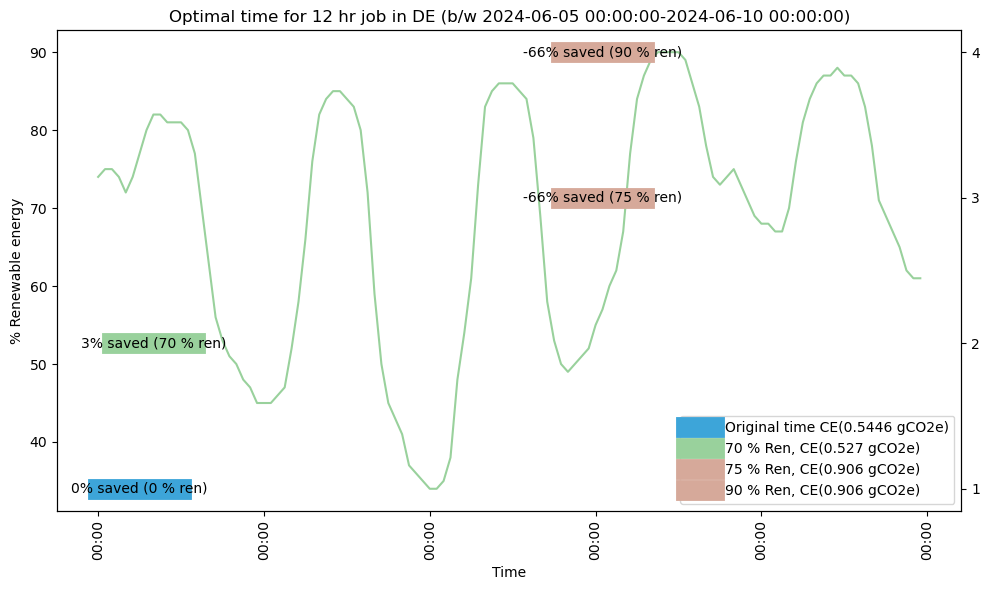

In [63]:
plot_optimal_time("DE",datetime(2024,6,5),datetime(2024,6,10),12,[70,75,90],32,24)

In [28]:
plot_optimal_time("DE",datetime(2024,5,5),datetime(2024,5,7),12,[70,75,90],124,64)

TypeError: get_carbon_emission() takes 6 positional arguments but 7 were given

In [29]:
plot_optimal_time("IT",datetime(2024,5,5),datetime(2024,5,7),8,[50,70,75,90],124,64)

TypeError: get_carbon_emission() takes 6 positional arguments but 7 were given

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = -2
returning requested timeslot
1714885200.0 Message.OPTIMAL_TIME 81.88888888888889
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = -2
returning requested timeslot
1714888800.0 Message.OPTIMAL_TIME 82.88888888888889
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = -2
1714867200.0 Message.OPTIMAL_TIME 70.33333333333333
[{'color': '#3DA5D9', 'label': 'Original time CE(1.0613 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 8, 0), 'emission': 1.0613, 'savings': 0, 'per': 0}, {'color': '#99D19C', 'label': '70 % Ren, CE(0.633 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 7, 0), 'end': datetime.datetime(2024, 5, 5, 15, 0), 'emission': 0.6326, 'savings': 40, 'per': 70}, {'color': '#99D19C', 'label': '75 % Ren, CE(0.638 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 8, 0),

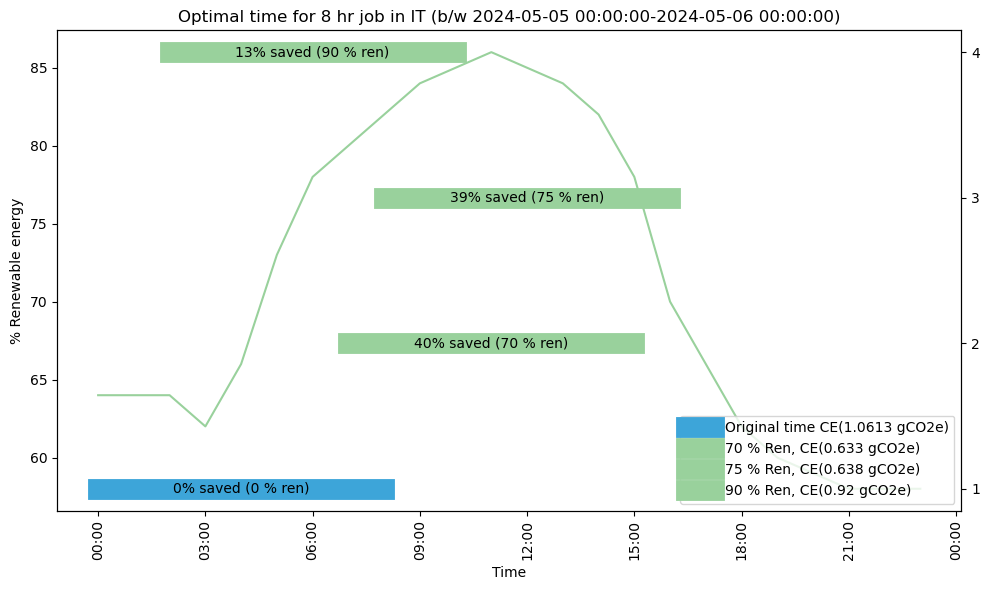

In [54]:
plot_optimal_time("IT",datetime(2024,5,5),datetime(2024,5,6),8,[70,75,90],124,64)

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 10:00:00+00:00
alternative = -8
returning requested timeslot
1714867200.0 Message.OPTIMAL_TIME 74.84615384615384
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 10:00:00+00:00
alternative = -8
1714867200.0 Message.OPTIMAL_TIME 74.84615384615384
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 10:00:00+00:00
alternative = -8
1714867200.0 Message.OPTIMAL_TIME 74.84615384615384
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 10:00:00+00:00
alternative = -8
1714867200.0 Message.OPTIMAL_TIME 74.84615384615384
[{'color': '#3DA5D9', 'label': 'Original time CE(0.3549 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 12, 0), 'emission': 0.3549, 'savings': 0, 'per': 0}, {'color': '#99D19C', 'label': '50 % Ren, CE(0.317 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 2, 0), 'end': datetime.datetime(2024, 5, 5, 14, 0), 'emission': 0.3168, 'savings': 1

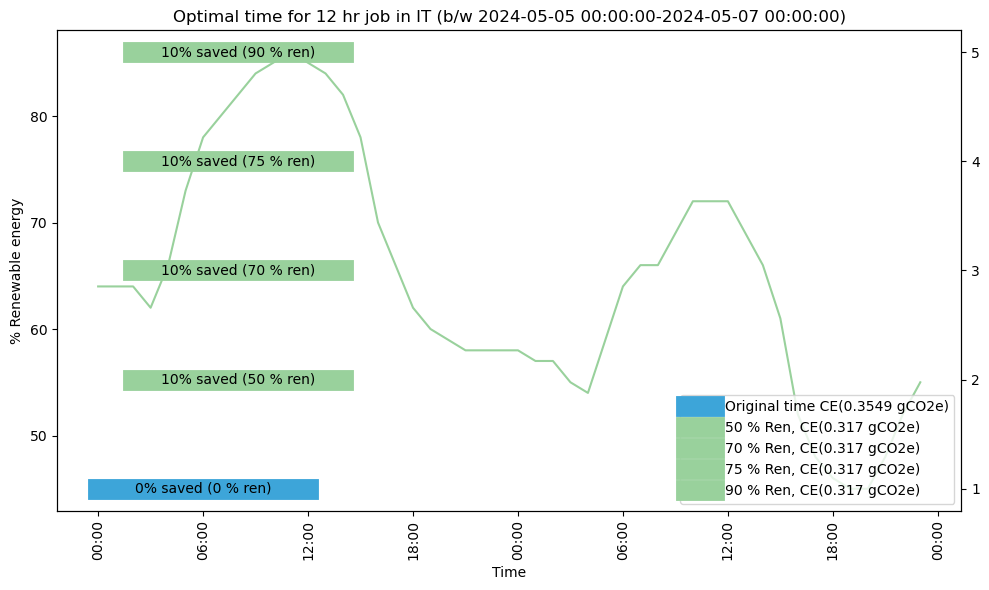

In [53]:
plot_optimal_time("IT",datetime(2024,5,5),datetime(2024,5,7),12,[50,70,75,90],32,24)

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = 24
returning optimum
1714953600.0 Message.OPTIMAL_TIME 29.0
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = 24
returning optimum
1714953600.0 Message.OPTIMAL_TIME 29.0
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = 24
returning optimum
1714953600.0 Message.OPTIMAL_TIME 29.0
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = 24
returning optimum
1714953600.0 Message.OPTIMAL_TIME 29.0
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = 24
returning optimum
1714953600.0 Message.OPTIMAL_TIME 29.0
[{'label': 'Original time CE(0.1108 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 8, 0), 'emission': 0.1108, 'savings': 0}, {'label': '40 % Ren, CE(0.102 gCO2e)', 'start': datetime.datetime(2024

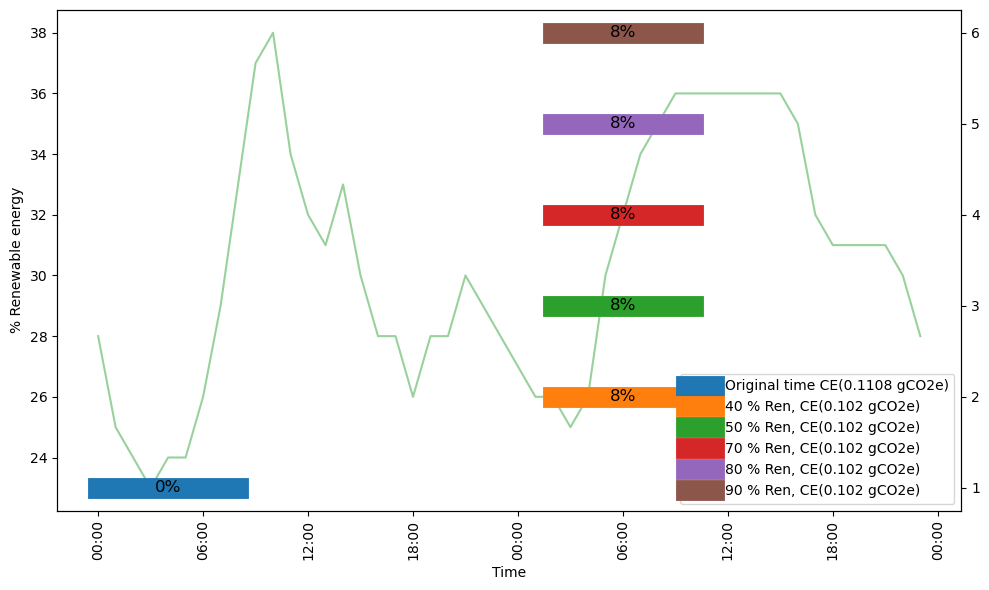

In [29]:
plot_optimal_time("FR",datetime(2024,5,5),datetime(2024,5,7),8,[40,50,70,80,90],124,64)

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 13:00:00+00:00
alternative = 15
returning optimum
1714921200.0 Message.OPTIMAL_TIME 27.9375
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 13:00:00+00:00
alternative = 15
returning optimum
1714921200.0 Message.OPTIMAL_TIME 27.9375
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 13:00:00+00:00
alternative = 15
returning optimum
1714921200.0 Message.OPTIMAL_TIME 27.9375
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 13:00:00+00:00
alternative = 15
returning optimum
1714921200.0 Message.OPTIMAL_TIME 27.9375
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 13:00:00+00:00
alternative = 15
returning optimum
1714921200.0 Message.OPTIMAL_TIME 27.9375
[{'label': 'Original time CE(0.23 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 15, 0), 'emission': 0.23, 'savings': 0}, {'label': '40 % Ren, CE(0.186 gCO2e)', 'start': datetime.d

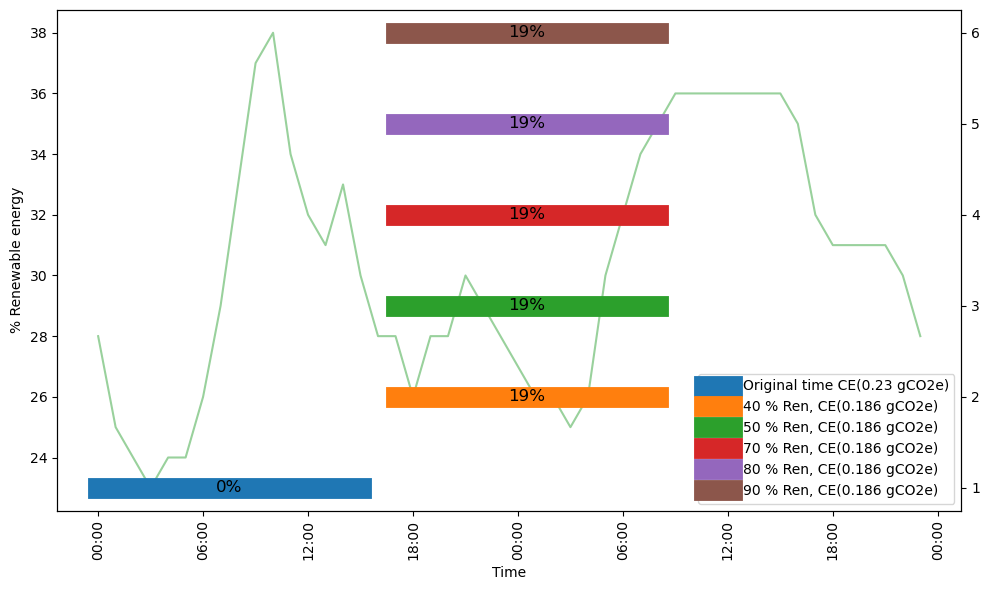

In [30]:
plot_optimal_time("FR",datetime(2024,5,5),datetime(2024,5,7),15,[40,50,70,80,90],124,64)

2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 13:00:00+00:00
alternative = -15
returning requested timeslot
1717545600.0 Message.OPTIMAL_TIME 77.1875
2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 13:00:00+00:00
alternative = -15
returning requested timeslot
1717545600.0 Message.OPTIMAL_TIME 77.1875
2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 13:00:00+00:00
alternative = -15
1717545600.0 Message.OPTIMAL_TIME 77.1875
2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 13:00:00+00:00
alternative = -15
1717545600.0 Message.OPTIMAL_TIME 77.1875
2024-06-04 22:00:00+00:00 2024-06-04 22:00:00+00:00 2024-06-05 13:00:00+00:00
alternative = -15
1717545600.0 Message.OPTIMAL_TIME 77.1875
[{'color': '#3DA5D9', 'label': 'Original time CE(0.6734 gCO2e)', 'start': datetime.datetime(2024, 6, 5, 0, 0), 'end': datetime.datetime(2024, 6, 5, 15, 0), 'emission': 0.6734, 'savings': 0, 'per': 0}, {'color': '#D6A99A', 'label': '50 % Ren, CE(0.702 g

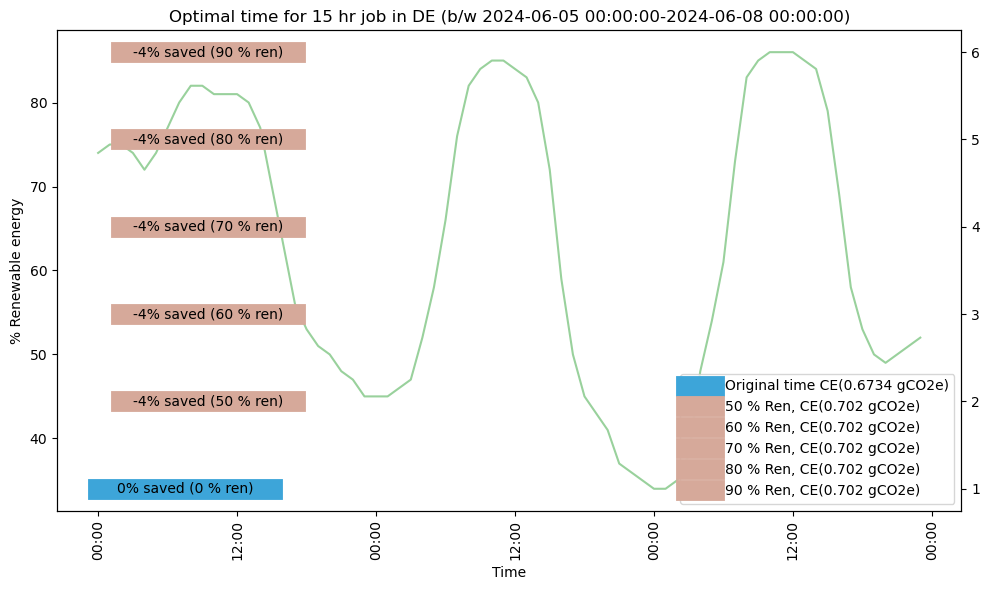

In [60]:
plot_optimal_time("DE",datetime(2024,6,5),datetime(2024,6,8),15,[50,60,70,80,90],32,24)

2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 23:00:00+00:00
alternative = 60
returning requested timeslot
1725926400.0 Message.OPTIMAL_TIME 77.07692307692308
2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 23:00:00+00:00
alternative = 60
returning requested timeslot
1725951600.0 Message.OPTIMAL_TIME 78.15384615384616
2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 23:00:00+00:00
alternative = 60
returning optimum
1726142400.0 Message.OPTIMAL_TIME 53.53846153846154
2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 23:00:00+00:00
alternative = 60
returning optimum
1726142400.0 Message.OPTIMAL_TIME 53.53846153846154
[{'color': '#3DA5D9', 'label': 'Original time CE(4.3858 gCO2e)', 'start': datetime.datetime(2024, 9, 10, 0, 0), 'end': datetime.datetime(2024, 9, 11, 1, 0), 'emission': 4.3858, 'savings': 0, 'per': 0}, {'color': '#D6A99A', 'label': '50 % Ren, CE(4.348 gCO2e)', 'start': datetime.datetime(2024, 9, 10, 2, 0), 'end': dat

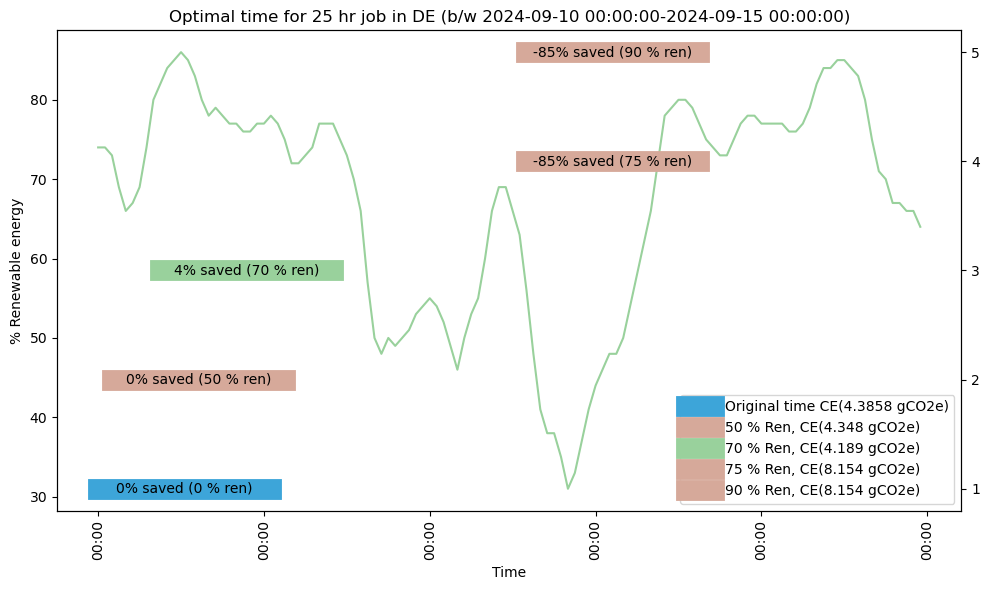

2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 18:00:00+00:00
alternative = 72
returning requested timeslot
1725926400.0 Message.OPTIMAL_TIME 77.14285714285714
2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 18:00:00+00:00
alternative = 72
returning requested timeslot
1725951600.0 Message.OPTIMAL_TIME 79.23809523809524
2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 18:00:00+00:00
alternative = 72
returning optimum
1726185600.0 Message.OPTIMAL_TIME 66.23809523809524
2024-09-09 22:00:00+00:00 2024-09-09 22:00:00+00:00 2024-09-10 18:00:00+00:00
alternative = 72
returning optimum
1726185600.0 Message.OPTIMAL_TIME 66.23809523809524
[{'color': '#3DA5D9', 'label': 'Original time CE(3.5013 gCO2e)', 'start': datetime.datetime(2024, 9, 10, 0, 0), 'end': datetime.datetime(2024, 9, 10, 20, 0), 'emission': 3.5013, 'savings': 0, 'per': 0}, {'color': '#99D19C', 'label': '50 % Ren, CE(3.455 gCO2e)', 'start': datetime.datetime(2024, 9, 10, 2, 0), 'end': da

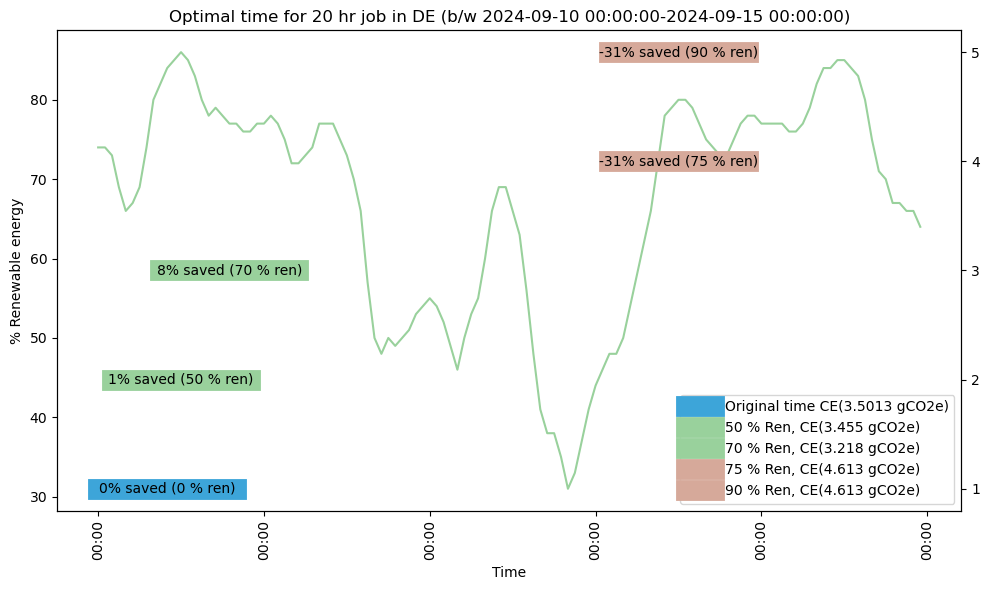

In [61]:
plot_optimal_time("DE",datetime(2024,9,10),datetime(2024,9,15),25,[50,70,75,90],124,64)
plot_optimal_time("DE",datetime(2024,9,10),datetime(2024,9,15),20,[50,70,75,90],124,64)

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = -1
returning requested timeslot
1714881600.0 Message.OPTIMAL_TIME 88.22222222222223
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = -1
returning requested timeslot
1714881600.0 Message.OPTIMAL_TIME 88.22222222222223
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 06:00:00+00:00
alternative = -1
1714867200.0 Message.OPTIMAL_TIME 74.11111111111111
[{'color': '#3DA5D9', 'label': 'Original time CE(1.7649 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 8, 0), 'emission': 1.7649, 'savings': 0, 'per': 0}, {'color': '#99D19C', 'label': '70 % Ren, CE(0.692 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 6, 0), 'end': datetime.datetime(2024, 5, 5, 14, 0), 'emission': 0.6916, 'savings': 60, 'per': 70}, {'color': '#99D19C', 'label': '75 % Ren, CE(0.692 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 6, 0),

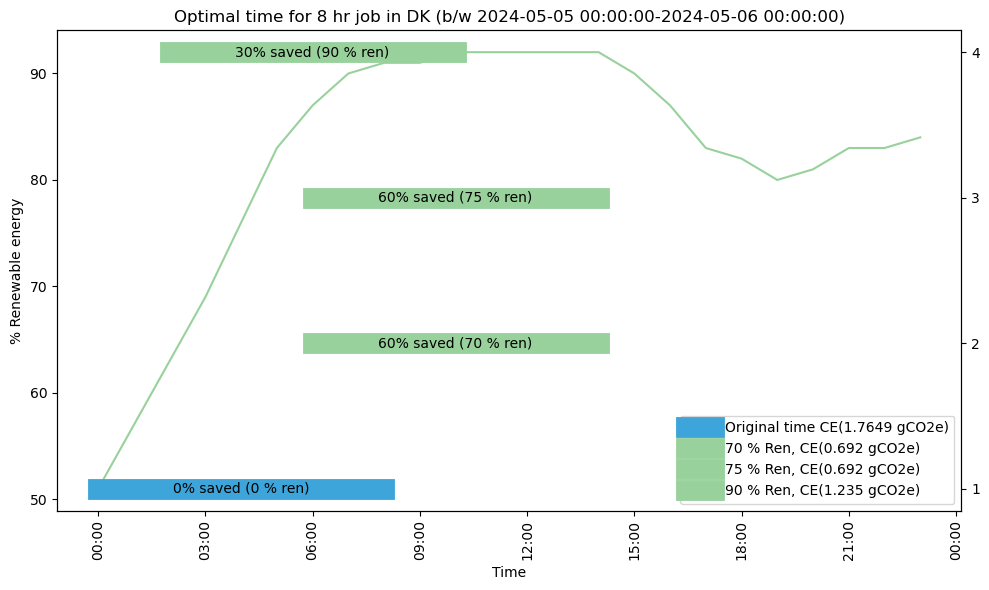

In [62]:
plot_optimal_time("DK",datetime(2024,5,5),datetime(2024,5,6),8,[70,75,90],124,64)

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 08:00:00+00:00
alternative = 2
returning optimum
1714874400.0 Message.OPTIMAL_TIME 66.0909090909091
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 08:00:00+00:00
alternative = 2
returning optimum
1714874400.0 Message.OPTIMAL_TIME 66.0909090909091
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 08:00:00+00:00
alternative = 2
returning optimum
1714874400.0 Message.OPTIMAL_TIME 66.0909090909091
[{'color': '#3DA5D9', 'label': 'Original time CE(0.1568 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 10, 0), 'emission': 0.1568, 'savings': 0, 'per': 0}, {'color': '#99D19C', 'label': '70 % Ren, CE(0.155 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 4, 0), 'end': datetime.datetime(2024, 5, 5, 14, 0), 'emission': 0.155, 'savings': 1, 'per': 70}, {'color': '#99D19C', 'label': '75 % Ren, CE(0.155 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 4, 0), 'end': dat

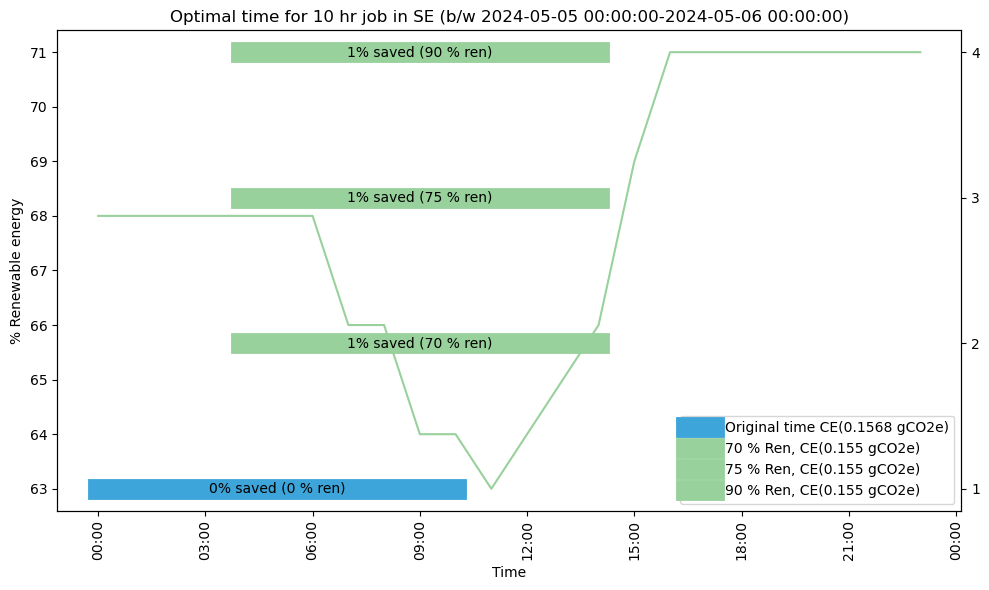

In [58]:
plot_optimal_time("SE",datetime(2024,5,5),datetime(2024,5,6),10,[70,75,90],124,64)

2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 08:00:00+00:00
alternative = 17
returning requested timeslot
1714964400.0 Message.OPTIMAL_TIME 71.63636363636364
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 08:00:00+00:00
alternative = 17
returning optimum
1714928400.0 Message.OPTIMAL_TIME 70.72727272727273
2024-05-04 22:00:00+00:00 2024-05-04 22:00:00+00:00 2024-05-05 08:00:00+00:00
alternative = 17
returning optimum
1714928400.0 Message.OPTIMAL_TIME 70.72727272727273
[{'color': '#3DA5D9', 'label': 'Original time CE(0.1568 gCO2e)', 'start': datetime.datetime(2024, 5, 5, 0, 0), 'end': datetime.datetime(2024, 5, 5, 10, 0), 'emission': 0.1568, 'savings': 0, 'per': 0}, {'color': '#D6A99A', 'label': '70 % Ren, CE(0.159 gCO2e)', 'start': datetime.datetime(2024, 5, 6, 5, 0), 'end': datetime.datetime(2024, 5, 6, 15, 0), 'emission': 0.1588, 'savings': -1, 'per': 70}, {'color': '#99D19C', 'label': '75 % Ren, CE(0.151 gCO2e)', 'start': datetime.datetime(2024, 5, 5

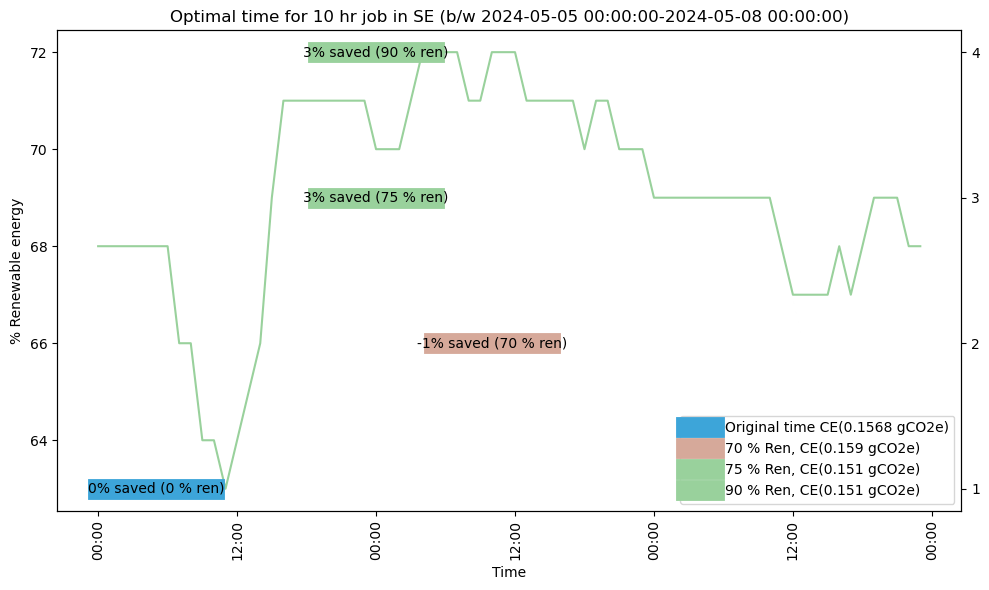

In [59]:
plot_optimal_time("SE",datetime(2024,5,5),datetime(2024,5,8),10,[70,75,90],124,64)

Plot saved to _static/CE_DE_1.png


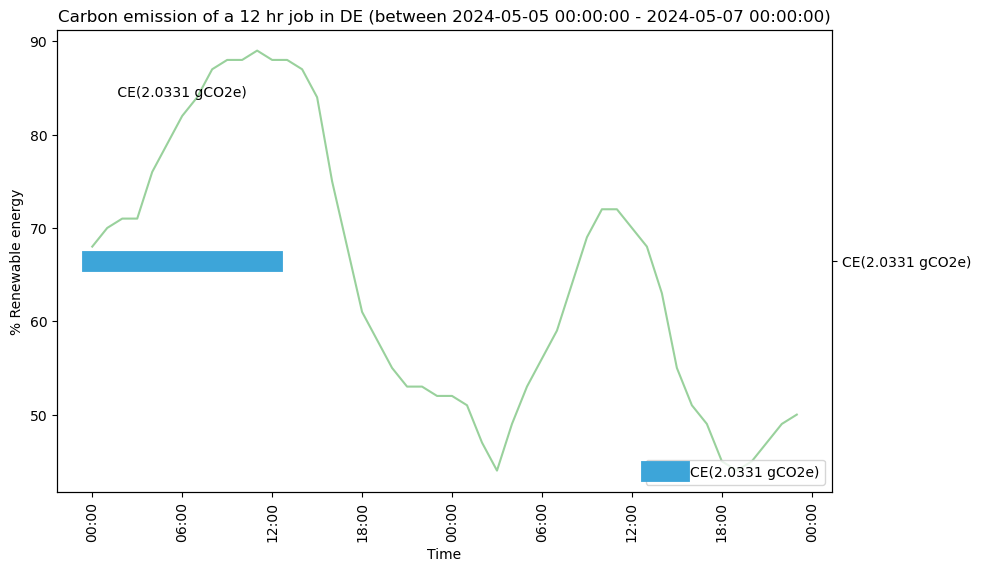

In [27]:
plot_carbon_emission_only("DE",datetime(2024,5,5),datetime(2024,5,7),12,124,64,"_static/CE_DE_1.png")

In [19]:
def get_carbon_emission(country, start, end, hour, n_cores, n_mem_gb):
    energy_data = energy(country, start, end)  # Assuming this function gets historical data
    # Convert the 'startTimeUTC' column to datetime
    energy_data['startTimeUTC'] = pd.to_datetime(energy_data['startTimeUTC'], utc=True)
    
    # Add 'posix_timestamp' column
    energy_data['posix_timestamp'] = energy_data['startTimeUTC'].astype(int) // 10**9  # Convert to POSIX timestamp (seconds)
    energy_data['percent_renewable'] = energy_data["percentRenewable"]

    # Calculate carbon emissions for the job
    current_start_time = start
    current_end_time = start + timedelta(hours=hour)
    current_emission, ce_ts = calculate_carbon_footprint_job(country, current_start_time, hour * 60, n_cores, n_mem_gb)

    # Create a list of jobs (in this case, just one job)
    jobs = [{
        "color": Color["blue"],
        "label": f"CE({current_emission} gCO2e)",
        "start": current_start_time,
        "end": current_end_time,
        "emission": current_emission,
        "savings": 0,
        "per": 0
    }]
    
    return energy_data, jobs

In [26]:
import os  # Import os for path handling

def plot_carbon_emission_only(country, start, end, hour, n_cores, n_mem_gb, path=None):
    energy_data, jobs = get_carbon_emission(country, start, end, hour, n_cores, n_mem_gb)
    
    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    plt.title(f"Carbon emission of a {hour} hr job in {country} (between {start} - {end})")
    
    # Plot percentage renewable energy
    ax1.plot(energy_data['startTimeUTC'], energy_data['percent_renewable'], color=Color['green'], label='Percentage Renewable')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('% Renewable energy')
    ax1.tick_params(axis='y')

    # Set x-axis to show dates properly
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=90)
    
    # Create a second y-axis
    ax2 = ax1.twinx()
    
    # Plot the job horizontally in the center of the graph
    job = jobs[0]  # Since there's only one job
    job_start = job['start']
    job_end = job['end']
    
    # Determine the y position for the job
    y_position = 0.5  # Set a constant y position for the job line
    
    # Draw the job line
    ax2.plot([job_start, job_end], [y_position, y_position], marker='o', linewidth=15, color=job['color'], label=job['label'])
    
    # Calculate the midpoint for the text placement
    midpoint = job_start + (job_end - job_start) / 2
    ax2.text(midpoint, y_position + 0.02, f" {job['label']} ", color='black', ha='center', va='center', fontsize=10)

    # Set the y-ticks to be only one label since there is only one job
    ax2.set_yticks([y_position])
    ax2.set_yticklabels([job['label']])
    
    # Add legend
    plt.legend(loc='lower right')
    
    # Save the figure if a path is provided
    if path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        # Save the plot as a PNG file
        plt.savefig(path, bbox_inches='tight')  # bbox_inches='tight' to fit the plot area nicely
        print(f"Plot saved to {path}")
    else:
        plt.show()  # Show the plot if no path is provided

# Random code

In [ ]:
from datetime import datetime,timedelta 
from codegreen_core.tools.loadshift_time import predict_now

country_code = "DK"
est_runtime_hour = 10
est_runtime_min = 0
now = datetime.now()
hard_finish_date = now + timedelta(days=1)
criteria = "percent_renewable"
per_renewable = 50 

time = predict_now(country_code,
                   est_runtime_hour,
                   est_runtime_min,
                   hard_finish_date,
                   criteria,
                   per_renewable)

In [ ]:
print(time)

In [12]:
import  codegreen_core.tools.loadshift_time as lt
from datetime import datetime
#.predict_now(country: str, estimated_runtime_hours: int, estimated_runtime_minutes: int, hard_finish_date: datetime, criteria: str = 'percent_renewable', percent_renewable: int = 50) → tuple¶
import importlib as il


In [47]:
res = lt.predict_now("ES",3,45,datetime(2024,10,18),"optimal_percent_renewable",50)  

             Solar  Wind Onshore  totalRenewable        startTimeUTC    total  \
group_id                                                                        
0            19.00       6522.00         6541.00 2024-10-17 00:00:00  21415.0   
1            28.75       6856.50         6885.25 2024-10-17 01:00:00  21133.0   
2            14.75       7203.00         7217.75 2024-10-17 02:00:00  21462.0   
3             6.25       7858.00         7864.25 2024-10-17 03:00:00  22678.0   
4             8.00       8553.75         8561.75 2024-10-17 04:00:00  23606.0   
5             4.00       9131.75         9135.75 2024-10-17 05:00:00  26592.0   
6           239.00       9597.00         9836.00 2024-10-17 06:00:00  28516.0   
7          3113.25      10064.75        13178.00 2024-10-17 07:00:00  32156.0   
8          7772.75      10718.00        18490.75 2024-10-17 08:00:00  35431.0   
9         10802.75      11390.50        22193.25 2024-10-17 09:00:00  38104.0   
10        12314.50      1201

In [48]:
print(res)

(1729152000.0, <Message.OPTIMAL_TIME: 'OPTIMAL_TIME'>, 60.0, 47.91)


In [46]:
il.reload(lt)

<module 'codegreen_core.tools.loadshift_time' from '/Users/svj/projects/codegreen/core/codegreen_core/tools/loadshift_time.py'>

In [94]:
from datetime import datetime,timedelta 
import codegreen_core.tools.carbon_emission as ce 

class Job:
    def __init__(self,name,start_time,duration_min,server):
        self.name = name
        self.start_time = start_time
        self.end_time = start_time + timedelta(minutes=duration_min)
        self.duration_min = duration_min
    def __repr__(self):
        return f"<Job: {self.name}, Start: {self.start_time}, End: {self.end_time}>"
    def get_ce(self,plot=False):
        """carbon emissions of this job. can only be calcualted for jobs in the past"""
        if datetime.now() < self.end_time:
            self.ce = ce.compute_ce()
        else:
            print("Carbon emissions can only be calcualted for jobs in the past since future energy data is not available")
            
        
        
    

class Server :
    def __init__(self,location,number_core,memory_gb,power_draw_core=15.8,power_draw_mem=0.3725,usage_factor_core=1,power_usage_efficiency=1.6):
        self.location = location
        self.number_core = number_core
        self.memory_gb = memory_gb
        self.power_draw_core = power_draw_core
        self.power_draw_mem = power_draw_mem
        self.usage_factor_core = usage_factor_core
        self.power_usage_efficiency = power_usage_efficiency
        self.jobs = {}
    def new_job(self,name,start_time,duration_min):
        if name not in self.jobs.keys():
            self.jobs[name] = Job(name,start_time,duration_min,self)
        else:
            print("job name already exists")    
    


In [90]:
s1 =  Server("DE",16,254)
s1.new_job("j1",datetime(2024,6,1),1200)

In [83]:
print(s1.jobs["j1"])

<Job: j1, Start: 2024-06-01 00:00:00, End: 2024-06-01 20:00:00>


In [92]:
ce1 = s1.jobs["j1"].get_ce()
print(ce1)

4
